In [1]:
## Import Packages
from __future__ import print_function

import numpy as np
import pandas as pd
from itertools import product

#Astro Software
import astropy.units as units
from astropy.coordinates import SkyCoord
from astropy.io import fits

#Plotting Packages
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns

from PIL import Image

from yt.config import ytcfg
import yt
import yt.units as u

#Scattering NN
import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering2D
device = "cpu"

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.decomposition import PCA, FastICA

import skimage
from skimage import filters

from scipy.optimize import curve_fit
from scipy import linalg
from scipy import stats
from scipy.signal import general_gaussian

#I/O
import h5py
import pickle
import glob
import copy
import time

#Plotting Style
%matplotlib inline
plt.style.use('dark_background')
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'

#Threading
torch.set_num_threads=2
from multiprocessing import Pool

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    out = os.path.splitext(tail)[0]
    return out

def hd5_open(file_name,name):
    f=h5py.File(file_name,'r', swmr=True)
    data = f[name][:]
    f.close()
    return data

from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1,N=5000)

In [3]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.datasets as ds

train_ds = ds.CIFAR100(root='./data_cache',train=True,download=True, transform=None)
test_ds = ds.CIFAR100(root='./data_cache',train=False,download=True, transform=None)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def LDA_AKS_testman(X_train,y_train,X_test,y_test,n_components,label_list):
    lda = LDA(n_components=n_components)
    X_train = lda.fit_transform(X_train, y_train)
    y_pred = lda.predict(X_test)
    X_test = lda.transform(X_test)
    cm = confusion_matrix(y_test, y_pred)
    prec = precision_score(y_test, y_pred,average='micro')
    print('Accuracy' + str(prec))
    cmap_normal = (cm.T/cm.sum(axis=1)).T
    
    ## Good plots
    vmin=y_train.min()
    vmax=y_train.max()
    marker_size = 10

    from matplotlib import cm as cmplt
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    rgba_colors = [cmplt.hsv(norm(indx)) for indx, i in enumerate(label_list)]
    color_order = ["black", "white"]
    color_map = "gray"
    colormap='hsv'
    
    fig = plt.figure(figsize=(12,12),dpi=150)

    ax = fig.add_subplot(2,2,1)    
    ax.imshow(cmap_normal,
          interpolation='nearest',
          cmap=color_map,
          aspect='equal',
          vmin=0,vmax=1)

    #ax.set_xticks(np.arange(cm.shape[0]))
    #ax.set_yticks(np.arange(cm.shape[1]))
    
    #for ytick, color in zip(ax.get_yticklabels(), rgba_colors):
    #    ytick.set_color(color)

    #ax.set_xticklabels(label_list)
    #ax.set_yticklabels(label_list)

    #plt.xlabel('Predicted Label')
    #plt.ylabel('True Label')

    #plt.setp(ax.get_xticklabels(), rotation=90, ha="right",va='center',
    #         rotation_mode="anchor")
    plt.title('Test-Train Fidelity ({:.2f}%)'.format(100*prec))

    # Loop over data dimensions and create text annotations.
    #textcolors=color_order
    #threshold = 0.5
    #for i in range(cm.shape[0]):
    #    for j in range(cm.shape[1]):
    #        if cm[i, j] != 0:
    #            text = ax.text(j, i, cm[i, j],
    #                           ha="center", va="center", 
     #                          color=textcolors[int(cmap_normal[i, j] < threshold)])
    if n_components == 1:
        ax = fig.add_subplot(2,2,2)
        #ax.scatter(X_train, y_train, s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
        #ax.scatter(X_test, y_test, s=2, marker='^', zorder=10,c=y_test, cmap = 'bwr',alpha=0.5)
        sns.distplot(X_test[y_test==0],ax=ax)
        sns.distplot(X_test[y_test==1],ax=ax)
        plt.xlabel('$LDA_{}$'.format(0))
        plt.ylabel('Probability Density')
        plt.title('LDA Projection')
        
    if n_components == 2:
        ax = fig.add_subplot(2,2,2)
        #ax.scatter(X_train[:,0], X_train[:,1], s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
        ax.scatter(X_test[:,0], X_test[:,1], s=2, marker='^', zorder=10,c=y_test, cmap = colormap, vmin=vmin, vmax=vmax,alpha=0.5)
        plt.xlabel('$LDA_{}$'.format(i-2))
        plt.ylabel('$LDA_{}$'.format(i-1))
        plt.title('LDA Projection')
    elif n_components > 2:
        for i in range(2,5):
            ax = fig.add_subplot(2,2,i)
            #ax.scatter(X_train[:,i-2], X_train[:,i-1], s=2, marker='o', zorder=10,c=y_train, cmap = 'bwr',alpha=0.5)
            ax.scatter(X_test[:,i-2], X_test[:,i-1], s=2, marker='^', zorder=10,c=y_test, cmap = colormap, vmin=vmin, vmax=vmax,alpha=0.5)
            plt.xlabel('$LDA_{}$'.format(i-2))
            plt.ylabel('$LDA_{}$'.format(i-1))
            plt.title('LDA Projection')

    fig.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()
    
    return (lda,cm,X_train,X_test,y_train,y_test,y_pred)

In [5]:
cifar100_trainy = hd5_open('cifar100_RGB.h5','main/train_labels')
cifar100_testy = hd5_open('cifar100_RGB.h5','main/test_labels')
cifar100_trainx_iso = hd5_open('cifar100_RGB.h5','main/train_data_iso').T
cifar100_testx_iso = hd5_open('cifar100_RGB.h5','main/test_data_iso').T

In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Accuracy0.244


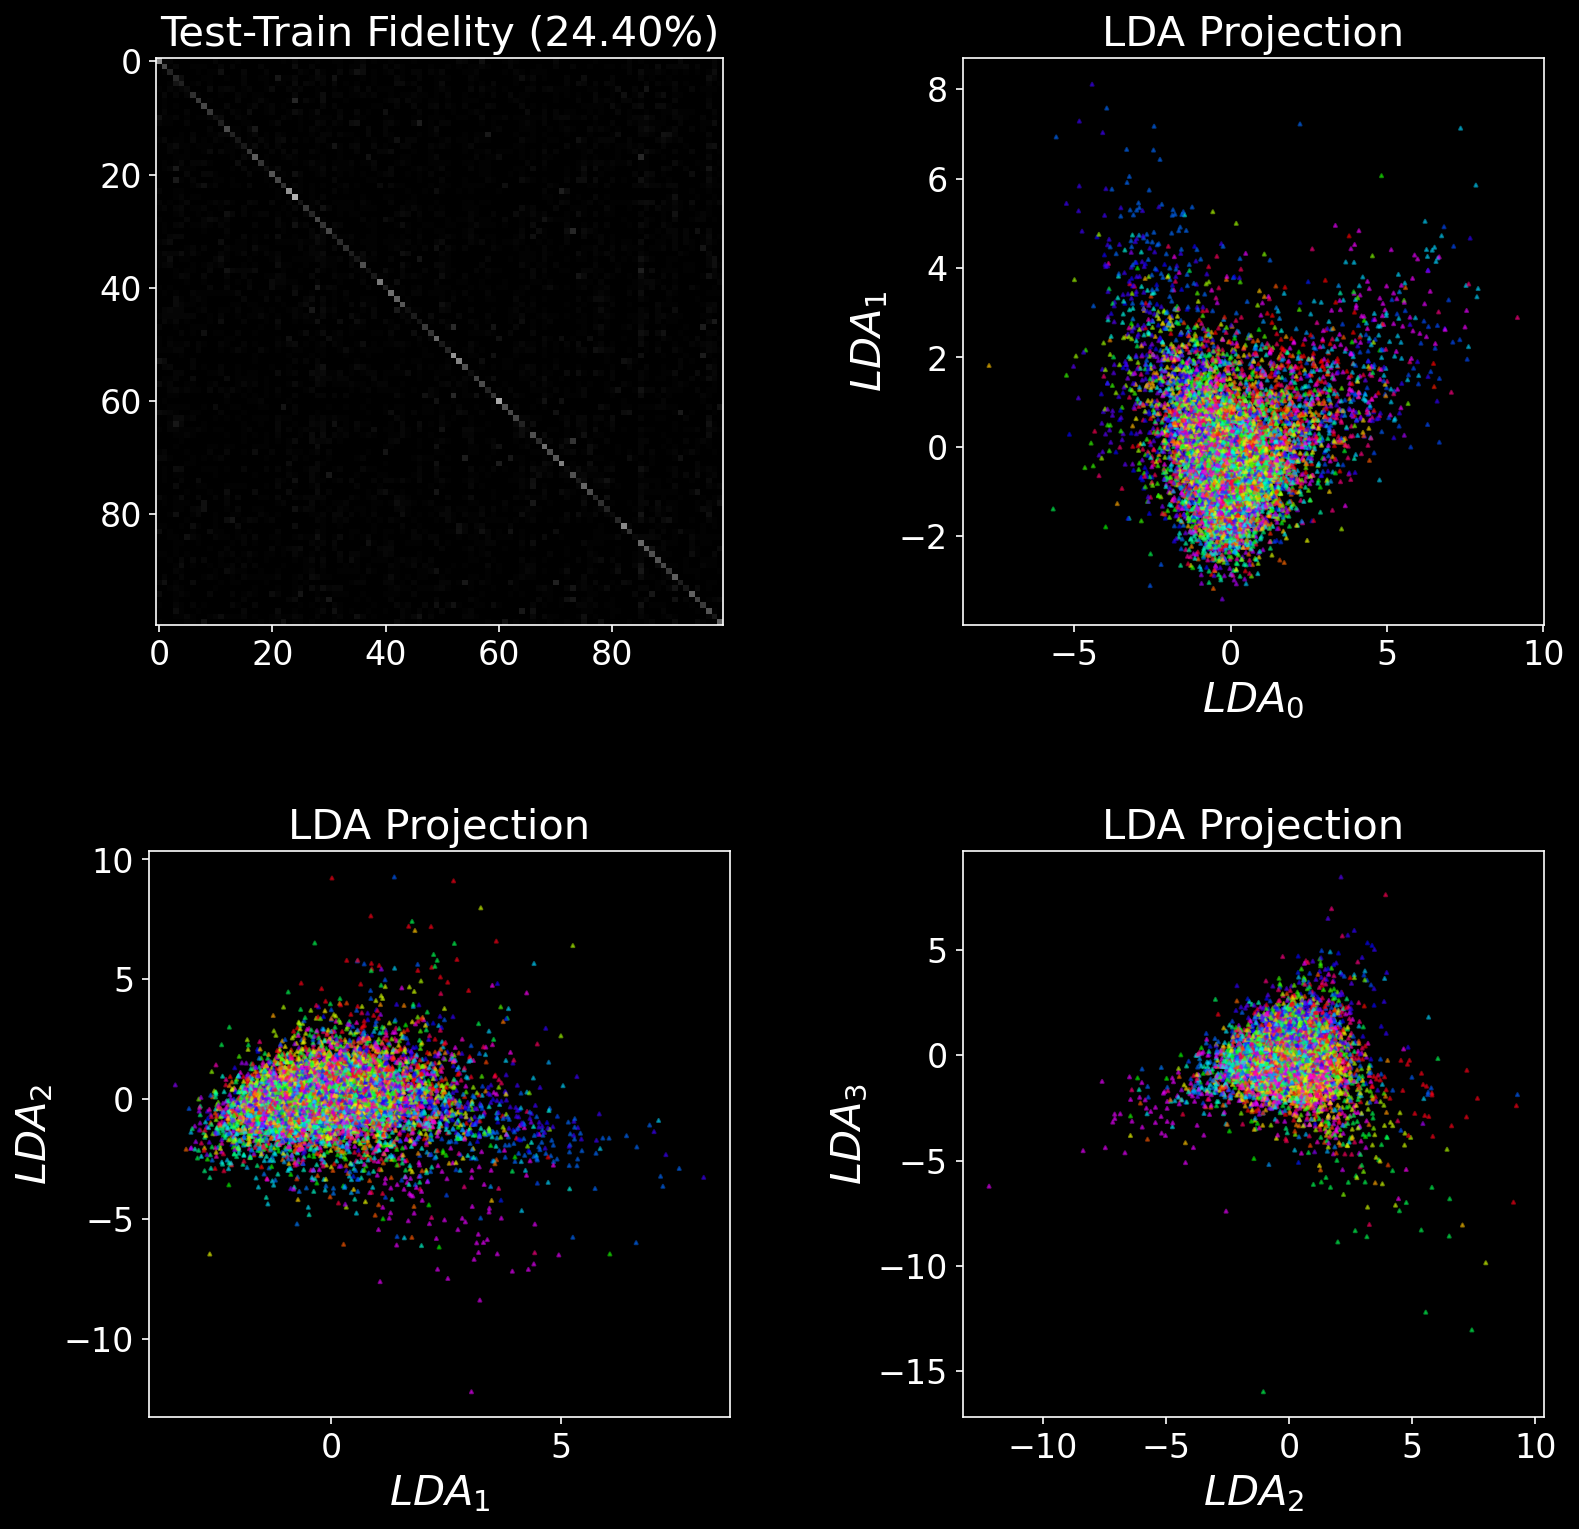

In [12]:
N = 100
labels = [i for i in range(100)]
out = LDA_AKS_testman(cifar100_trainx_iso,
                      np.array(train_ds.targets),
                      cifar100_testx_iso,
                      np.array(test_ds.targets),N-1,labels)

Accuracy0.3403


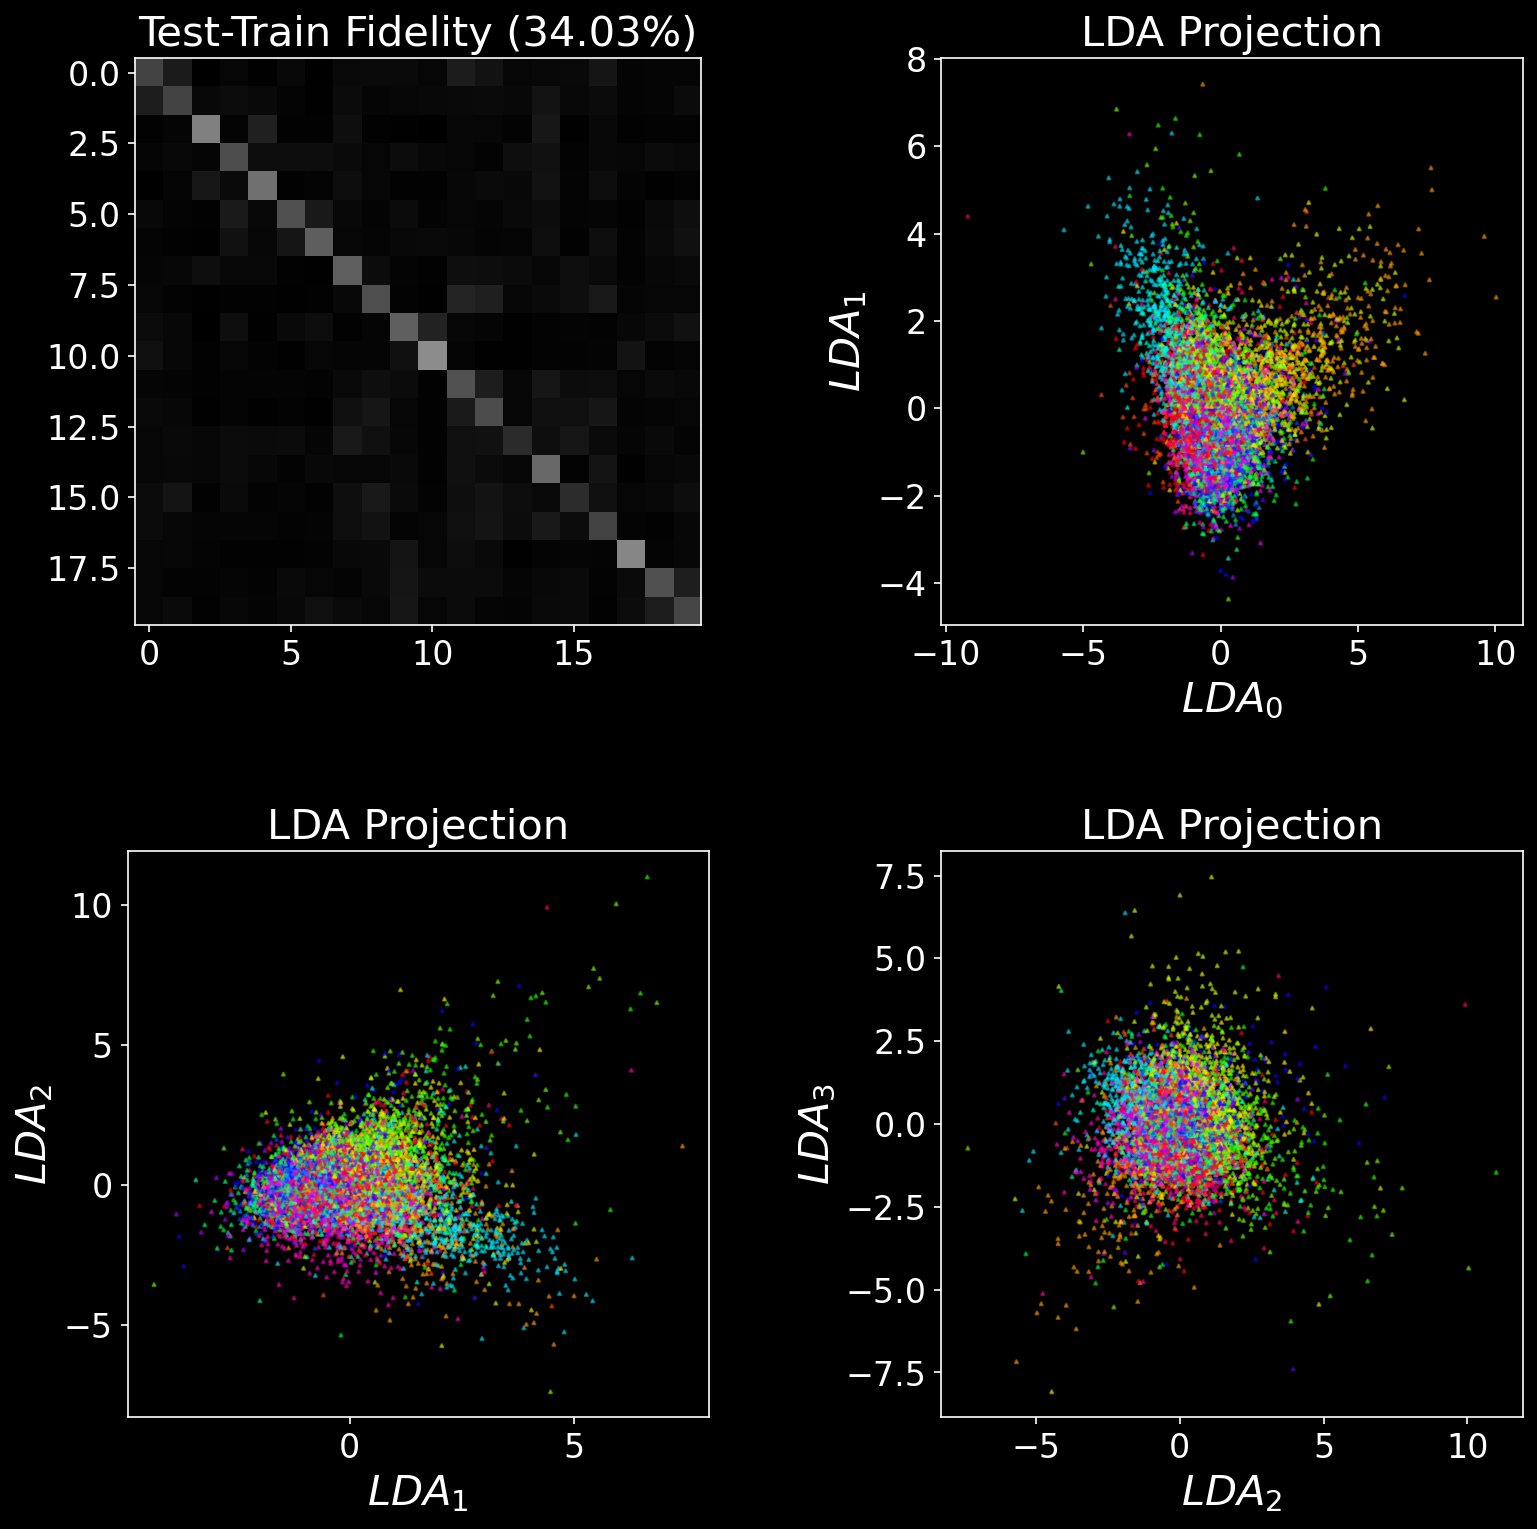

In [14]:
N = 20
labels = [i for i in range(20)]
out = LDA_AKS_testman(cifar100_trainx_iso,
                      cifar100_trainy,
                      cifar100_testx_iso,
                      cifar100_testy,N-1,labels)

In [2]:
color_list = ["RGB","YCbCr","YIQ","HSV","HSL","HSI","Lab","Luv","LCHab","LCHuv","LMS","xyY","XYZ","DIN99","DIN99d","DIN99o"]

In [3]:
def LDA_AKS_testman(X_train,y_train,X_test,y_test,n_components):
    lda = LDA(n_components=n_components)
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    y_pred_train = lda.predict(X_train)
    prec = precision_score(y_test, y_pred,average='micro')
    prec_train = precision_score(y_train, y_pred_train,average='micro')
    print(prec, prec_train)
    return prec, prec_train

In [4]:
N = 20
labels = [i for i in range(20)]

In [25]:
prec_list = np.zeros(16)
prec_train_list = np.zeros(16)
for indx, i in enumerate(color_list):
    cifar100_trainy = hd5_open('cifar100_{}.h5'.format(i),'main/train_labels')
    cifar100_testy = hd5_open('cifar100_{}.h5'.format(i),'main/test_labels')
    cifar100_trainx_iso = hd5_open('cifar100_{}.h5'.format(i),'main/train_data_iso').T
    cifar100_testx_iso = hd5_open('cifar100_{}.h5'.format(i),'main/test_data_iso').T
    if np.count_nonzero(np.isnan(cifar100_testx_iso)) != 0:
        print(np.count_nonzero(np.isnan(cifar100_testx_iso)))
        cifar100_trainx_iso[np.isnan(cifar100_trainx_iso)] = 1e-12
        cifar100_testx_iso[np.isnan(cifar100_testx_iso)] = 1e-12
    prec_list[indx], prec_train_list[indx] = LDA_AKS_testman(cifar100_trainx_iso,
                       cifar100_trainy,
                       cifar100_testx_iso,
                       cifar100_testy,N-1)

0.3403 0.39982
0.3502 0.41406
0.3567 0.42152
261018
0.3388 0.40708
261018
0.3256 0.39796
163251
0.3363 0.40308
0.3517 0.41674
0.349 0.41336
0.3463 0.41304
0.3436 0.40714
0.3152 0.367
1173030
0.3189 0.38936
0.315 0.3652
0.3513 0.41996
0.3559 0.419
0.3575 0.41936


In [27]:
hf = h5py.File('cifar_proccesing.h5', 'w')
hf.create_dataset('cifar100_prec', data=prec_list)
hf.create_dataset('cifar100_precTrain', data=prec_train_list)
hf.close()

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
prec_list = np.zeros(16)
prec_train_list = np.zeros(16)
for indx, i in enumerate(color_list):
    cifar100_trainy = hd5_open('cifar100_{}.h5'.format(i),'main/train_labels')
    cifar100_testy = hd5_open('cifar100_{}.h5'.format(i),'main/test_labels')
    cifar100_trainx_iso = hd5_open('cifar100_{}.h5'.format(i),'main/train_data_iso').T
    cifar100_testx_iso = hd5_open('cifar100_{}.h5'.format(i),'main/test_data_iso').T
    sc = StandardScaler()
    X_tr = sc.fit_transform(cifar100_trainx_iso)
    X_tst = sc.transform(cifar100_testx_iso)
    if np.count_nonzero(np.isnan(X_tst)) != 0:
        print(np.count_nonzero(np.isnan(X_tst)))
        X_tr[np.isnan(X_tr)] = 1e-12
        X_tst[np.isnan(X_tst)] = 1e-12
    prec_list[indx], prec_train_list[indx] = LDA_AKS_testman(X_tr,
                       cifar100_trainy,
                       X_tst,
                       cifar100_testy,N-1)

0.3403 0.39982
0.3502 0.41406
0.3567 0.42152
261018
0.337 0.40682
261018
0.3261 0.39698
163251
0.3363 0.40312
0.3517 0.41674
0.349 0.41336
0.3463 0.41304
0.3436 0.40714
0.3152 0.367
1173030
0.3186 0.38794
0.315 0.3652
0.3513 0.41996
0.3559 0.419
0.3575 0.41936


In [8]:
hf = h5py.File('cifar_proccesing.h5', 'a')
hf.create_dataset('cifar100_prec_sc', data=prec_list)
hf.create_dataset('cifar100_precTrain_sc', data=prec_train_list)
hf.close()

In [10]:
prec_list = np.zeros(16)
prec_train_list = np.zeros(16)
for indx, i in enumerate(color_list):
    cifar100_trainy = hd5_open('cifar100_{}.h5'.format(i),'main/train_labels')
    cifar100_testy = hd5_open('cifar100_{}.h5'.format(i),'main/test_labels')
    cifar100_trainx_iso = hd5_open('cifar100_{}.h5'.format(i),'main/train_data_iso').T
    cifar100_testx_iso = hd5_open('cifar100_{}.h5'.format(i),'main/test_data_iso').T
    sc = StandardScaler()
    X_tr = sc.fit_transform(np.log10(cifar100_trainx_iso+1e-12))
    X_tst = sc.transform(np.log10(cifar100_testx_iso+1e-12))
    if np.count_nonzero(np.isnan(X_tst)) != 0:
        print(np.count_nonzero(np.isnan(X_tst)))
        X_tr[np.isnan(X_tr)] = 1e-12
        X_tst[np.isnan(X_tst)] = 1e-12
    prec_list[indx], prec_train_list[indx] = LDA_AKS_testman(X_tr,
                       cifar100_trainy,
                       X_tst,
                       cifar100_testy,N-1)

0.3563 0.41684
0.3742 0.4457


/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


8682
0.3699 0.43746
261018
0.3444 0.41774
261018
0.3324 0.40896
163251
0.3516 0.4212


/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


6094
0.3562 0.4322


/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


5452
0.363 0.43508
0.3549 0.4213
0.3567 0.42344
0.3388 0.39366
1173030
0.3432 0.41384
0.3396 0.39106


/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


5561
0.352 0.42992


/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


6926
0.3622 0.4352


/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


6010
0.3602 0.4319


In [11]:
hf = h5py.File('cifar_proccesing.h5', 'a')
hf.create_dataset('cifar100_prec_sc_log', data=prec_list)
hf.create_dataset('cifar100_precTrain_sc_log', data=prec_train_list)
hf.close()

In [12]:
N = 10
labels = [i for i in range(10)]

In [13]:
prec_list = np.zeros(16)
prec_train_list = np.zeros(16)
for indx, i in enumerate(color_list):
    cifar100_trainy = hd5_open('cifar10_{}.h5'.format(i),'main/train_labels')
    cifar100_testy = hd5_open('cifar10_{}.h5'.format(i),'main/test_labels')
    cifar100_trainx_iso = hd5_open('cifar10_{}.h5'.format(i),'main/train_data_iso').T
    cifar100_testx_iso = hd5_open('cifar10_{}.h5'.format(i),'main/test_data_iso').T
    if np.count_nonzero(np.isnan(cifar100_testx_iso)) != 0:
        print(np.count_nonzero(np.isnan(cifar100_testx_iso)))
        cifar100_trainx_iso[np.isnan(cifar100_trainx_iso)] = 1e-12
        cifar100_testx_iso[np.isnan(cifar100_testx_iso)] = 1e-12
    prec_list[indx], prec_train_list[indx] = LDA_AKS_testman(cifar100_trainx_iso,
                       cifar100_trainy,
                       cifar100_testx_iso,
                       cifar100_testy,N-1)

0.4858 0.52522
0.513 0.55324
0.5179 0.55186
180836
0.5067 0.54756
180836
0.4949 0.53604
113102
0.5023 0.54384
0.5166 0.55816
0.5219 0.55782
0.5098 0.55
0.5106 0.55032
0.4555 0.49246
1311486
0.4795 0.51828
0.4534 0.48984
0.5208 0.56406
0.5178 0.56536
0.517 0.56138


In [14]:
hf = h5py.File('cifar_proccesing.h5', 'a')
hf.create_dataset('cifar10_prec', data=prec_list)
hf.create_dataset('cifar10_precTrain', data=prec_train_list)
hf.close()

In [15]:
prec_list = np.zeros(16)
prec_train_list = np.zeros(16)
for indx, i in enumerate(color_list):
    cifar100_trainy = hd5_open('cifar10_{}.h5'.format(i),'main/train_labels')
    cifar100_testy = hd5_open('cifar10_{}.h5'.format(i),'main/test_labels')
    cifar100_trainx_iso = hd5_open('cifar10_{}.h5'.format(i),'main/train_data_iso').T
    cifar100_testx_iso = hd5_open('cifar10_{}.h5'.format(i),'main/test_data_iso').T
    sc = StandardScaler()
    X_tr = sc.fit_transform(cifar100_trainx_iso)
    X_tst = sc.transform(cifar100_testx_iso)
    if np.count_nonzero(np.isnan(X_tst)) != 0:
        print(np.count_nonzero(np.isnan(X_tst)))
        X_tr[np.isnan(X_tr)] = 1e-12
        X_tst[np.isnan(X_tst)] = 1e-12
    prec_list[indx], prec_train_list[indx] = LDA_AKS_testman(X_tr,
                       cifar100_trainy,
                       X_tst,
                       cifar100_testy,N-1)

0.4858 0.52522
0.513 0.55324
0.5179 0.55186
180836
0.5056 0.54624
180836
0.4932 0.5356
113102
0.5023 0.54386
0.5166 0.55816
0.5219 0.55782
0.5098 0.55
0.5106 0.55032
0.4555 0.49246
1311486
0.4736 0.51328
0.4534 0.48984
0.5208 0.56406
0.5178 0.56536
0.517 0.56138


In [16]:
hf = h5py.File('cifar_proccesing.h5', 'a')
hf.create_dataset('cifar10_prec_sc', data=prec_list)
hf.create_dataset('cifar10_precTrain_sc', data=prec_train_list)
hf.close()

In [17]:
prec_list = np.zeros(16)
prec_train_list = np.zeros(16)
for indx, i in enumerate(color_list):
    cifar100_trainy = hd5_open('cifar10_{}.h5'.format(i),'main/train_labels')
    cifar100_testy = hd5_open('cifar10_{}.h5'.format(i),'main/test_labels')
    cifar100_trainx_iso = hd5_open('cifar10_{}.h5'.format(i),'main/train_data_iso').T
    cifar100_testx_iso = hd5_open('cifar10_{}.h5'.format(i),'main/test_data_iso').T
    sc = StandardScaler()
    X_tr = sc.fit_transform(np.log10(cifar100_trainx_iso+1e-12))
    X_tst = sc.transform(np.log10(cifar100_testx_iso+1e-12))
    if np.count_nonzero(np.isnan(X_tst)) != 0:
        print(np.count_nonzero(np.isnan(X_tst)))
        X_tr[np.isnan(X_tr)] = 1e-12
        X_tst[np.isnan(X_tst)] = 1e-12
    prec_list[indx], prec_train_list[indx] = LDA_AKS_testman(X_tr,
                       cifar100_trainy,
                       X_tst,
                       cifar100_testy,N-1)

0.5027 0.54546
0.5393 0.57478


/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


9204
0.5308 0.56918
180836
0.5222 0.56522
180836
0.515 0.55584
113102
0.5255 0.56422


/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


7119
0.5254 0.567


/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


6647
0.5338 0.57012
0.5297 0.56818
0.5313 0.56878
0.48 0.52198
1311486
0.4991 0.53298
0.4795 0.52114


/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


6732
0.5334 0.57064


/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


8205
0.5276 0.57052


/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/n/home12/saydjari/.conda/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


7061
0.5324 0.5687


In [18]:
hf = h5py.File('cifar_proccesing.h5', 'a')
hf.create_dataset('cifar10_prec_sc_log', data=prec_list)
hf.create_dataset('cifar10_precTrain_sc_log', data=prec_train_list)
hf.close()